**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 57 kB 3.0 MB/s 


In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170498071/170498071 [==============================] - 2s 0us/step


Q1: The 60000 data points are split with training ratio of 0.8 leading to 60000*0.8 = 48000 training points. 

At 32 per iteration, we have 48000/32 = 1500 iterations to go through the entire training set. Therefore in 30 epochs we have 30*1500 = 45000


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
print(model.vars())

(ConvNet).conv_1(Sequential)[0](Conv2D).b       16 (16, 1, 1)
(ConvNet).conv_1(Sequential)[0](Conv2D).w      192 (2, 2, 3, 16)
(ConvNet).conv_2(Sequential)[0](Conv2D).b       32 (32, 1, 1)
(ConvNet).conv_2(Sequential)[0](Conv2D).w     2048 (2, 2, 16, 32)
(ConvNet).linear(Linear).b                      10 (10,)
(ConvNet).linear(Linear).w                     320 (32, 10)
+Total(6)                                     2618


Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, we take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



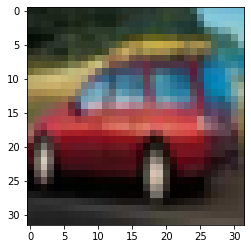

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine.

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

objax_conv_output = Conv2d(my_image)

print("Filter weights:", filter_weights, filter_weights.shape)
print("Conv output:", objax_conv_output)
print("Conv output shape:", np.shape(objax_conv_output))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]] (1, 1, 3, 2)
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem
def my_conv_net(my_image, initial_filter_weights):
  my_conv_output = np.zeros((1, 2, 32, 32))
  for i in range(32):
    for j in range(32):
      my_conv_output[0, :, i, j] = np.matmul(initial_filter_weights[0, 0].T, my_image[0, :, i, j])
  
  return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights)
print(my_conv_output)
print(np.allclose(objax_conv_output, my_conv_output)) # Will be true

[[[[-0.10271907 -0.10010862 -0.09076816 ... -0.74204231 -0.73912485
    -0.73746224]
   [-0.12882357 -0.11180527 -0.11687266 ... -0.7310544  -0.74346105
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911371 -0.71740328
    -0.71560835]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.1117876  -0.11439805
    -0.1222294 ]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353442 -0.08614487 ... -0.16399661 -0.16138616
    -0.15355481]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253252  0.7320599
     0.72146261]
   [ 0.14844203  0.12636711  0.1275416  ...  0.77934483  0.7626404
     0.75807608]
   [ 0.15300635  0.12562042  0.15036321 ...  0.79253835  0.77845234
     0.77533194]
   ...
   [ 0.20083014  0.1917015   0.1917015  ...  0.27218535  0.27674967
     0.29044263]
   [ 0.16887989  0.15975125  0.15975125 ...  0.29957127  0.29500695
     0.29500695]
   [ 0.15062261  0.14605828  0.15062261 ...  0.3634

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_mean = my_conv_output.mean((2,3))

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#PUT YOUR CODE HERE
Linear_Layer = objax.nn.Linear(2, 1)
Y = Linear_Layer(my_mean)
print(Y)

w = Linear_Layer.w.value
b = Linear_Layer.b.value

# One line manual implementation
Y_manual = my_mean @ w + b

print(Y_manual) # Will be same as Y


[[-0.70484114]]
[[-0.70484114]]


Part 1. Problem 4

In short, training sets are used to tune the *parameters* whereas validation sets are used to tune the *hyperparameters*. Training sets are used to determine optimal weights, biases, kernels, etc. Validation sets are used to determine optimal hyper-parameters (learning rate, stride, kernel size, etc.)

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
###########################################
# NOTE: I put training routine "train_op" #
# into the body of train() to allow users #
# to specify the model they want to train #
###########################################

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4, MODEL=model):
  #Define loss function as averaged value of of cross entropies
  def loss_function(x, labels):
      logit = MODEL(x)
      return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

  #Define a prediction function
  predict = objax.Jit(lambda x: objax.functional.softmax(MODEL(x)), MODEL.vars()) 

  #Create an object that can be used to calculate the gradient and value of loss_function
  gv = objax.GradValues(loss_function, MODEL.vars())

  #Create an object that can be used to provide trainable variables in the model
  tv = objax.ModuleList(objax.TrainRef(x) for x in MODEL.vars().subset(objax.TrainVar))

  #Training routine
  def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr * grad
    return loss_value                      # return loss value

  #make train_op (much) faster using JIT compilation
  train_op = objax.Jit(train_op, gv.vars() + tv.vars())


  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it : it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it : it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.20 Validation Loss 2.20 Training Accuracy 18.29 Validation Accuracy 18.23
Epoch 0002  Training Loss 2.20 Validation Loss 2.19 Training Accuracy 18.60 Validation Accuracy 19.38
Epoch 0003  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 19.02 Validation Accuracy 19.68
Epoch 0004  Training Loss 2.18 Validation Loss 2.17 Training Accuracy 19.53 Validation Accuracy 20.20
Epoch 0005  Training Loss 2.17 Validation Loss 2.16 Training Accuracy 19.79 Validation Accuracy 20.37
Epoch 0006  Training Loss 2.16 Validation Loss 2.15 Training Accuracy 20.24 Validation Accuracy 20.33
Epoch 0007  Training Loss 2.15 Validation Loss 2.14 Training Accuracy 20.40 Validation Accuracy 20.20
Epoch 0008  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.35 Validation Accuracy 20.58
Epoch 0009  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.69 Validation Accuracy 20.72
Epoch 0010  Training Loss 2.13 Validation Loss 2.12 Training Accuracy 21.06 Valida

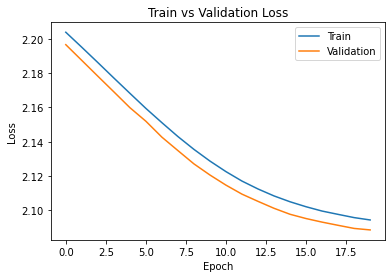

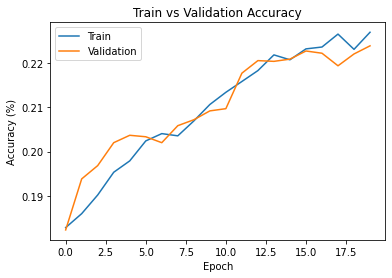

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

Question 4: In one sentence, define the meaning of a “hyperparameter”. explain in a short paragraph why it is important not to evaluate the accuracy on the test set until all hyperparameters have been tuned

A hyper-parameter is a value which we tune to improve the generalization of a model, pertaining to it's architecture or training process. 

Evaluating accuracy on the test set will lead to overfitting the hyperparameters to the test set.

5) My set of hyperparameters is:

H = {size of convolution kernel, stride, number of outputs of first conv layer, batch size}

H_1 = { 3, 2, 8, 16 }

H_2 = { 4, 3, 32, 64 }

In [ ]:
# 6

# M1
class ConvNetM1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 3, strides=2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 3, strides=2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x


# M2
class ConvNetM2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M1 = ConvNetM1()
M2 = ConvNetM2()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.49 Validation Accuracy 14.30
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.28 Validation Accuracy 13.28
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.22 Validation Accuracy 15.17
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 15.69 Validation Accuracy 17.28
Epoch 0005  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 17.53 Validation Accuracy 17.98
Epoch 0006  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 19.00 Validation Accuracy 18.47
Epoch 0007  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 20.11 Validation Accuracy 21.70
Epoch 0008  Training Loss 2.23 Validation Loss 2.21 Training Accuracy 21.76 Validation Accuracy 23.33
Epoch 0009  Training Loss 2.19 Validation Loss 2.17 Training Accuracy 24.32 Validation Accuracy 25.38
Epoch 0010  Training Loss 2.14 Validation Loss 2.12 Training Accuracy 26.35 Valida

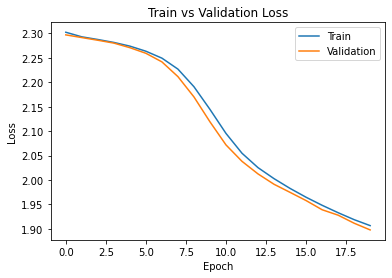

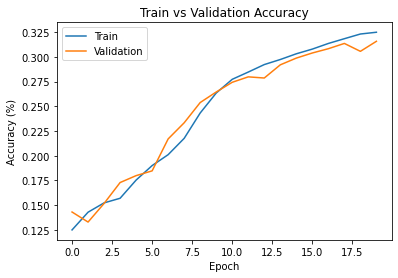

In [ ]:
train(MODEL=M1, BATCH=16)

Epoch 0001  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 17.26 Validation Accuracy 17.85
Epoch 0002  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 17.79 Validation Accuracy 17.68
Epoch 0003  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 17.63 Validation Accuracy 17.87
Epoch 0004  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 17.67 Validation Accuracy 18.08
Epoch 0005  Training Loss 2.22 Validation Loss 2.22 Training Accuracy 18.01 Validation Accuracy 18.15
Epoch 0006  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 18.18 Validation Accuracy 18.33
Epoch 0007  Training Loss 2.21 Validation Loss 2.21 Training Accuracy 18.08 Validation Accuracy 18.65
Epoch 0008  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 18.70 Validation Accuracy 18.40
Epoch 0009  Training Loss 2.20 Validation Loss 2.20 Training Accuracy 18.38 Validation Accuracy 18.95
Epoch 0010  Training Loss 2.20 Validation Loss 2.19 Training Accuracy 18.89 Valida

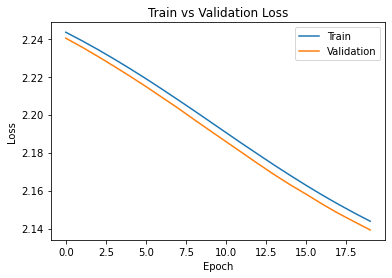

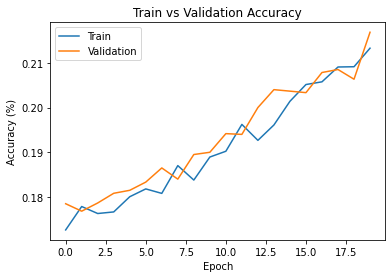

In [ ]:
train(MODEL=M2, BATCH=64)

Base Best Validation accuracy: 22.38% @ Epoch 20

M1 Best Validation accuracy: 31.58% @ Epoch 20

M2 Best Validation accuracy: 21.68% @ Epoch 20

It's worth noting that M1 appeared to be approaching convergence (i.e. the loss/accuracy graphs were plateauing) by the time it reached epoch 20, whereas both the base model and M2 were clearly still training. Regardless, **M1 had an impressive best validation accuracy of 31.58%**, an unexpected result due to having a smaller convolutional layer output size and smaller kernel than M2


In [ ]:
# 7) Based on your answer, which model should you pick as your final model and
#    why? Then evaluate your model on the test set and report final test accuracy


# Due to M1's higher accuracy and faster convergence I would pick M1
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 
test_prediction = predict(X_test).argmax(1)
accuracy = (np.array(test_prediction).flatten() == Y_test).sum()
print(100 * accuracy / X_test.shape[0])

30.8


**The final result is a test accuracy of 30.8**, only slightly below the validation accuracy of 31.8 and training accuracy of 32.5, indicating that we have done a good job avoiding overfitting.

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()     # CHANGED THIS LINE
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
class ConvNetM3(objax.Module):
  # Same as ConvNetM1, but with 3 conv layers, and the second layer outputs 24 channels instead of 32
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 3, strides=2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 4, 3, strides=4), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(4, 24, 3, strides=2), objax.functional.relu])
    self.linear = objax.nn.Linear(24, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = self.conv_3(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

M3 = ConvNetM3()

Epoch 0001  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.82 Validation Accuracy 0.97
Epoch 0002  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.86 Validation Accuracy 0.98
Epoch 0003  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.85 Validation Accuracy 1.02
Epoch 0004  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.88 Validation Accuracy 1.07
Epoch 0005  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.94 Validation Accuracy 1.07
Epoch 0006  Training Loss 4.60 Validation Loss 4.61 Training Accuracy 1.00 Validation Accuracy 1.10
Epoch 0007  Training Loss 4.60 Validation Loss 4.61 Training Accuracy 1.03 Validation Accuracy 1.08
Epoch 0008  Training Loss 4.60 Validation Loss 4.61 Training Accuracy 1.03 Validation Accuracy 1.05
Epoch 0009  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.04 Validation Accuracy 1.02
Epoch 0010  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.04 Validation Accuracy 1.03


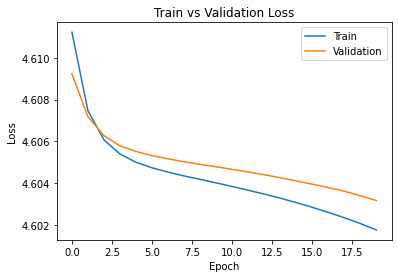

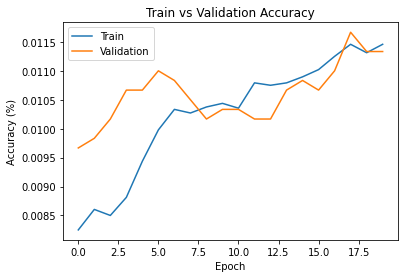

In [ ]:
train(MODEL=M3)

The base model performs very poorly, with a max validation accuracy of only 1.17% at Epoch 18. To correct this we will tune the number of layers, width of layers, and kernel size

In [ ]:
class ConvNetM4(objax.Module):
  # Same as ConvNetM1, but with 3 conv layers, and the second layer outputs 24 channels instead of 32
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 2, strides=2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 4, strides=4), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

M4 = ConvNetM4()

Epoch 0001  Training Loss 4.61 Validation Loss 4.60 Training Accuracy 1.29 Validation Accuracy 1.13
Epoch 0002  Training Loss 4.59 Validation Loss 4.59 Training Accuracy 1.84 Validation Accuracy 1.60
Epoch 0003  Training Loss 4.59 Validation Loss 4.59 Training Accuracy 2.07 Validation Accuracy 1.87
Epoch 0004  Training Loss 4.59 Validation Loss 4.59 Training Accuracy 2.31 Validation Accuracy 2.00
Epoch 0005  Training Loss 4.58 Validation Loss 4.58 Training Accuracy 2.43 Validation Accuracy 2.08
Epoch 0006  Training Loss 4.58 Validation Loss 4.58 Training Accuracy 2.49 Validation Accuracy 2.28
Epoch 0007  Training Loss 4.57 Validation Loss 4.57 Training Accuracy 2.60 Validation Accuracy 2.33
Epoch 0008  Training Loss 4.56 Validation Loss 4.56 Training Accuracy 2.72 Validation Accuracy 2.48
Epoch 0009  Training Loss 4.56 Validation Loss 4.55 Training Accuracy 2.78 Validation Accuracy 2.50
Epoch 0010  Training Loss 4.55 Validation Loss 4.54 Training Accuracy 2.79 Validation Accuracy 2.45


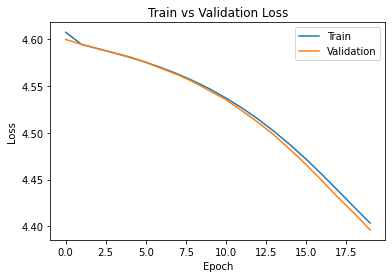

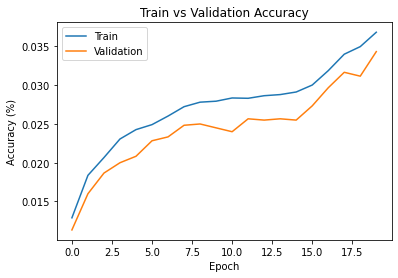

In [ ]:
train(MODEL=M4)

This yields a much better result, however we can do better by increasing the learning rate.

Epoch 0001  Training Loss 4.60 Validation Loss 4.59 Training Accuracy 1.55 Validation Accuracy 1.38
Epoch 0002  Training Loss 4.59 Validation Loss 4.58 Training Accuracy 1.85 Validation Accuracy 1.93
Epoch 0003  Training Loss 4.57 Validation Loss 4.56 Training Accuracy 2.35 Validation Accuracy 1.90
Epoch 0004  Training Loss 4.55 Validation Loss 4.53 Training Accuracy 3.26 Validation Accuracy 3.47
Epoch 0005  Training Loss 4.51 Validation Loss 4.49 Training Accuracy 3.88 Validation Accuracy 3.45
Epoch 0006  Training Loss 4.47 Validation Loss 4.44 Training Accuracy 3.79 Validation Accuracy 3.93
Epoch 0007  Training Loss 4.41 Validation Loss 4.38 Training Accuracy 4.23 Validation Accuracy 3.95
Epoch 0008  Training Loss 4.35 Validation Loss 4.33 Training Accuracy 4.72 Validation Accuracy 4.72
Epoch 0009  Training Loss 4.31 Validation Loss 4.30 Training Accuracy 5.50 Validation Accuracy 5.17
Epoch 0010  Training Loss 4.28 Validation Loss 4.27 Training Accuracy 5.96 Validation Accuracy 5.90


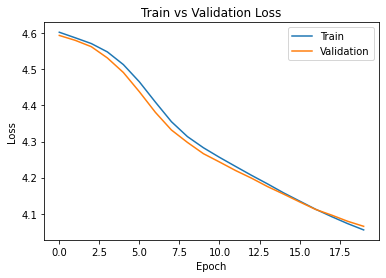

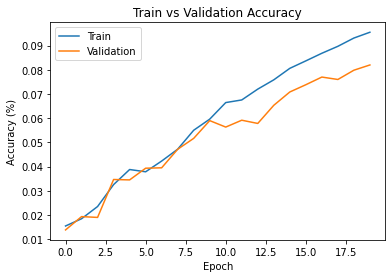

In [ ]:
M5 = ConvNetM4()
train(MODEL=M5, LEARNING_RATE=3e-3)

This yields a max validation accuracy of 8.2, which is a significant improvement over the base model. However, the large divergence of training accuracy and validation accuracy suggests that the model may be overfitting. We will select this as our final model and determine test accuracy.

In [ ]:
# 4

predict = objax.Jit(lambda x: objax.functional.softmax(M4(x)), M4.vars()) 
test_prediction = predict(X_test).argmax(1)
accuracy = (np.array(test_prediction).flatten() == Y_test).sum()
print(100 * accuracy / X_test.shape[0])

3.55


Notice that the training accuracy is only 3.55, significantly lower than the training and validation accuracies of 9.5 and 8.2, respectively. This tells us that the model has indeed overfit to the training/validation data. This is likely due to the extreme width of the network.

##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

1. Additional hyperparameter tuning Come up with one or several hyperparameters that you have not tried in the previous parts (e.g., explore arguments of the method objax.nn.Cov2d), tune them on the validation set until you see (at-least) 5%-10% increase in the validation accuracy as compared to a base model. Discuss whether it performs well on the test set as compared to your base model

We will try tuning the padding and activation functions, using M4 as the base model. We will set padding to "VALID" (meaning no padding) and the activation function as sigmoid.

In [ ]:
class ConvNetM6(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 2, strides=2, padding="VALID"), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 4, strides=4, padding="VALID"), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

Epoch 0001  Training Loss 4.66 Validation Loss 4.64 Training Accuracy 1.01 Validation Accuracy 1.05
Epoch 0002  Training Loss 4.63 Validation Loss 4.62 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0003  Training Loss 4.62 Validation Loss 4.62 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0004  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0005  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0006  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0007  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0008  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0009  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.05
Epoch 0010  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.02 Validation Accuracy 1.03


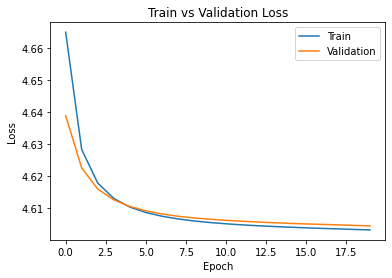

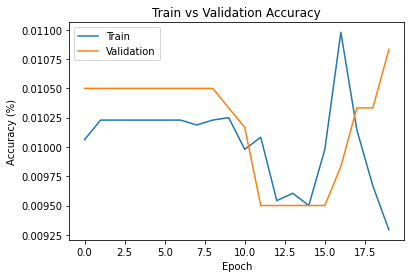

In [ ]:
M6 = ConvNetM6()
train(MODEL=M6)

Interestingly, the training process does not improve the performance of the model. We will adjust by setting the padding back to "SAME" and trying the leaky RELU activation function

In [ ]:
class ConvNetM7(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 2, strides=2), objax.functional.leaky_relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 4, strides=4), objax.functional.leaky_relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

Epoch 0001  Training Loss 4.61 Validation Loss 4.60 Training Accuracy 1.09 Validation Accuracy 1.13
Epoch 0002  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.22 Validation Accuracy 1.25
Epoch 0003  Training Loss 4.60 Validation Loss 4.59 Training Accuracy 1.49 Validation Accuracy 1.13
Epoch 0004  Training Loss 4.59 Validation Loss 4.59 Training Accuracy 1.51 Validation Accuracy 1.35
Epoch 0005  Training Loss 4.59 Validation Loss 4.59 Training Accuracy 1.57 Validation Accuracy 1.63
Epoch 0006  Training Loss 4.58 Validation Loss 4.58 Training Accuracy 1.71 Validation Accuracy 1.67
Epoch 0007  Training Loss 4.58 Validation Loss 4.58 Training Accuracy 1.72 Validation Accuracy 1.45
Epoch 0008  Training Loss 4.57 Validation Loss 4.57 Training Accuracy 1.82 Validation Accuracy 1.98
Epoch 0009  Training Loss 4.57 Validation Loss 4.57 Training Accuracy 2.03 Validation Accuracy 1.77
Epoch 0010  Training Loss 4.56 Validation Loss 4.56 Training Accuracy 2.26 Validation Accuracy 1.90


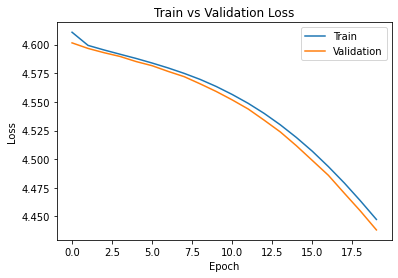

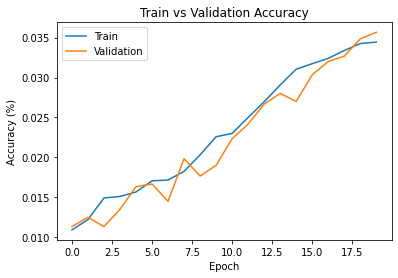

In [ ]:
M7 = ConvNetM7()
train(MODEL=M7)

Unfortunately, this also does not improve the learning process. We at this point will note that online resources suggest that ReLU is the best activation function fore CNN's, so when comparing M6 (Which uses sigmoid as it's activation function, max validation accuracy of 1.08), to M4 (ReLU, mqx validation accuracy of 3.43)  we observe an increase in validation accuracy.